# Проект: классификация

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, OrdinalEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [283]:
df = pd.read_csv('bank_fin\\bank_fin.csv', sep = ';')

In [284]:
# Суммарная информация о пропущенных значениях по каждому столбцу
missing_per_column = df.isnull().sum()

# Только столбцы, где есть пропуски
missing_per_column = missing_per_column[missing_per_column > 0]

print(f"Столбцы с пропущенными значениями и их количество: {missing_per_column}")

Столбцы с пропущенными значениями и их количество: balance    25
dtype: int64


### Задание 2

In [285]:
for job in df['job'].unique():
    print(job)

admin.
technician
services
management
retired
blue-collar
unemployed
entrepreneur
housemaid
unknown
self-employed
student


### Задание 3

In [286]:
# Удаляем пробелы, $, и запятые, затем преобразуем к float
df['balance'] = df['balance'].astype(str) \
    .str.replace(' ', '') \
    .str.replace(',', '.') \
    .str.replace('$', '') \
    .astype(float)

# Вычисляем среднее, округляем до 3 знаков
mean_balance = round(df['balance'].mean(), 3)

# Убираем лишние нули
formatted_balance = f"{mean_balance:.3f}".rstrip('0').rstrip('.')

print(f'Среднее значение с округлением до 3 знаков: {formatted_balance}')


Среднее значение с округлением до 3 знаков: 1529.129


### Задание 4

In [287]:
# Преобразуем в числовой тип (ошибки — в NaN)
df['balance'] = pd.to_numeric(df['balance'], errors='coerce')

# Вычисляем медиану
median_balance = df['balance'].median()
print(f"Медианное значение баланса: {median_balance}")

# Заполняем пропуски медианой
df['balance'] = df['balance'].fillna(median_balance)

# Вычисляем среднее значение и округляем до трёх знаков
mean_balance = round(df['balance'].mean(), 3)
print(f"Среднее значение баланса: {mean_balance}")


Медианное значение баланса: 550.0
Среднее значение баланса: 1526.936


### Задание 5

In [288]:
# Для job
job_mode = df.loc[df['job'] != 'unknown', 'job'].mode()[0]
df['job'] = df['job'].replace('unknown', job_mode)

# Для education
education_mode = df.loc[df['education'] != 'unknown', 'education'].mode()[0]
df['education'] = df['education'].replace('unknown', education_mode)

# Выбираем нужных клиентов
popular_clients = df[(df['job'] == job_mode) & (df['education'] == education_mode)]

# Считаем средний баланс, округляем до трёх знаков
mean_balance_popular = round(popular_clients['balance'].mean(), 3)
print(f'Средний баланс популярных клиентов: {mean_balance_popular}')

Средний баланс популярных клиентов: 1598.883


### Задание 6

In [289]:
# 1. Квартиль и IQR
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

# 2. Границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')

# 3. Фильтрация — оставим только значения в этих пределах
df_no_outliers = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

# Проверим результат — например, количество строк до и после фильтрации
print('Число строк до фильтрации:', len(df))
print('Число строк после фильтрации:', len(df_no_outliers))

Нижняя граница: -2241.0
Верхняя граница: 4063.0
Число строк до фильтрации: 11162
Число строк после фильтрации: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5873
yes    5289
Name: count, dtype: int64


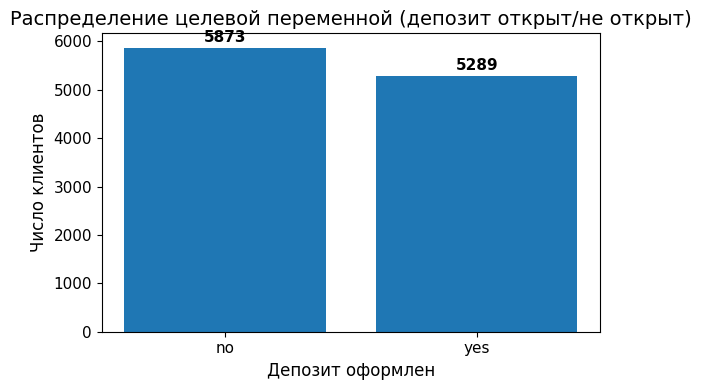

In [290]:
# Частоты по целевой переменной
deposit_counts = df['deposit'].value_counts()
print(deposit_counts)

plt.figure(figsize=(6,4))
bars = plt.bar(deposit_counts.index, deposit_counts.values)
plt.title('Распределение целевой переменной (депозит открыт/не открыт)', fontsize=14)
plt.xlabel('Депозит оформлен', fontsize=12)
plt.ylabel('Число клиентов', fontsize=12)

# Оформим подписи на столбиках
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

### Задания 2 и 3

Максимальный возраст клиента банка: 95
Минимальная продолжительность разговора с клиентом (сек): 2


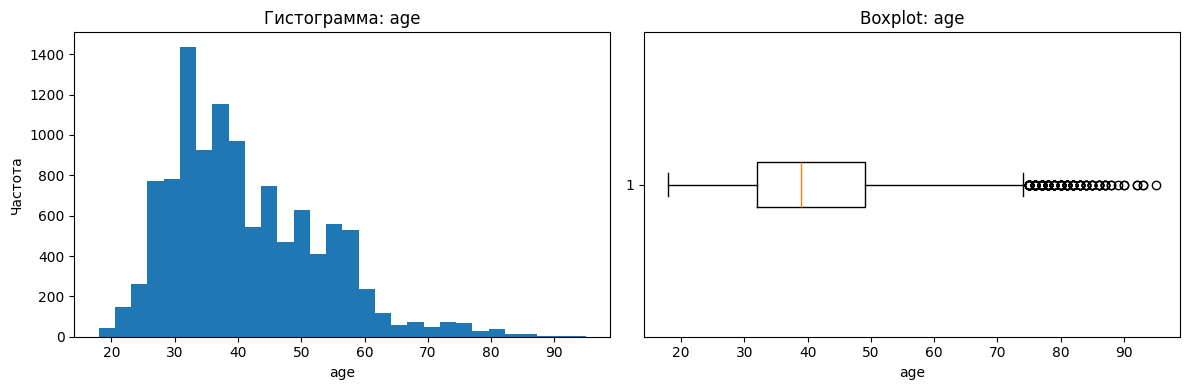

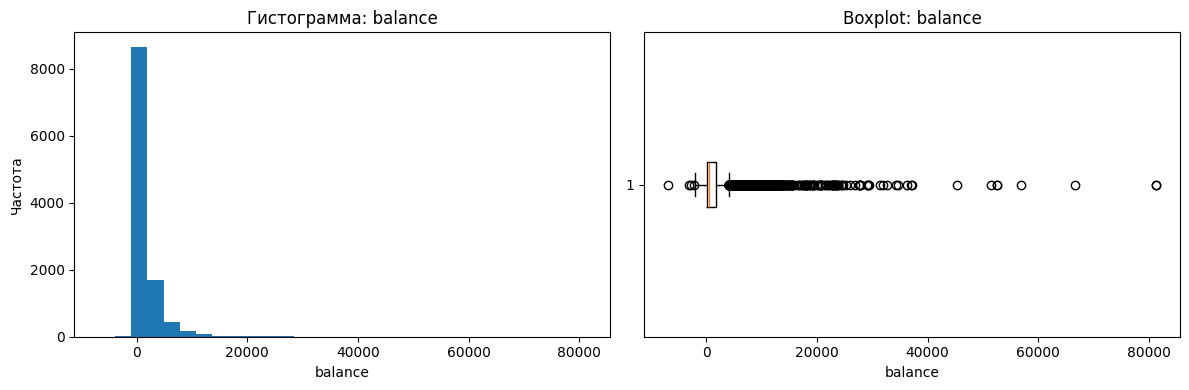

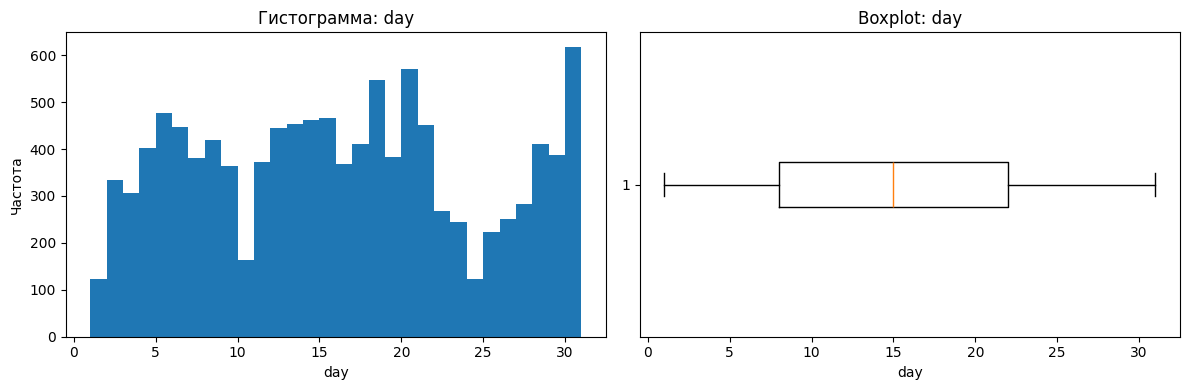

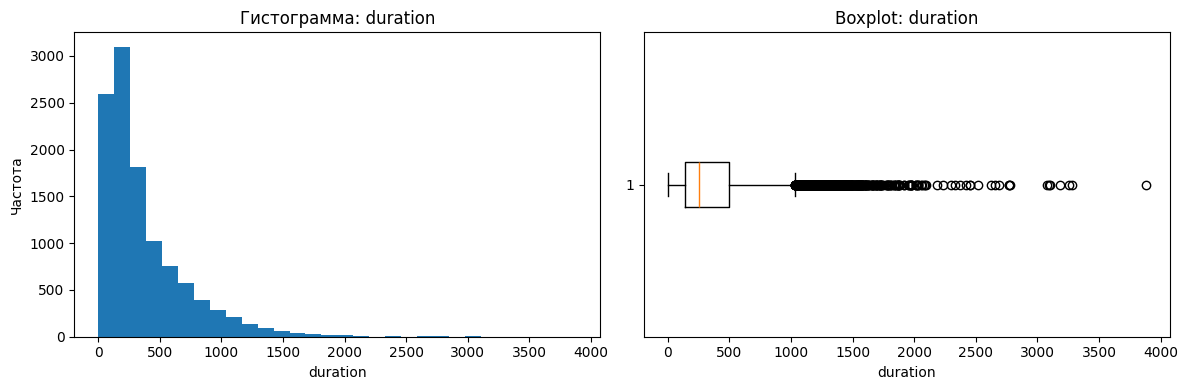

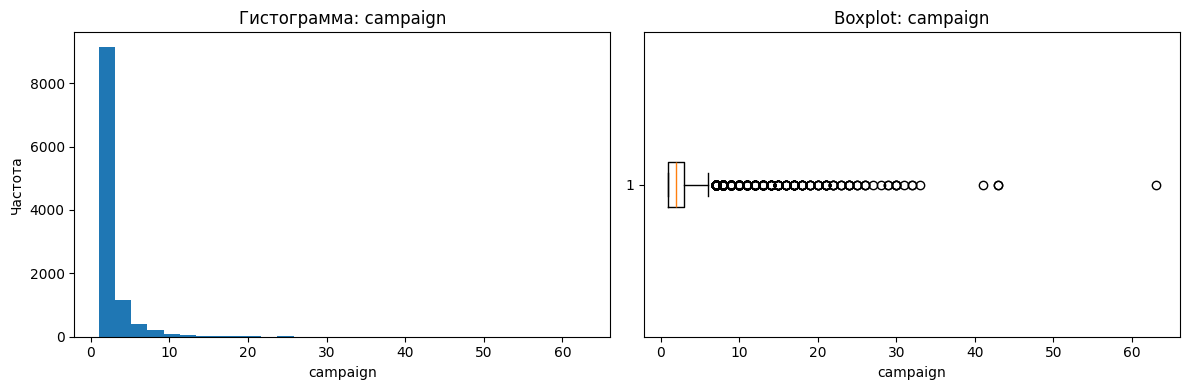

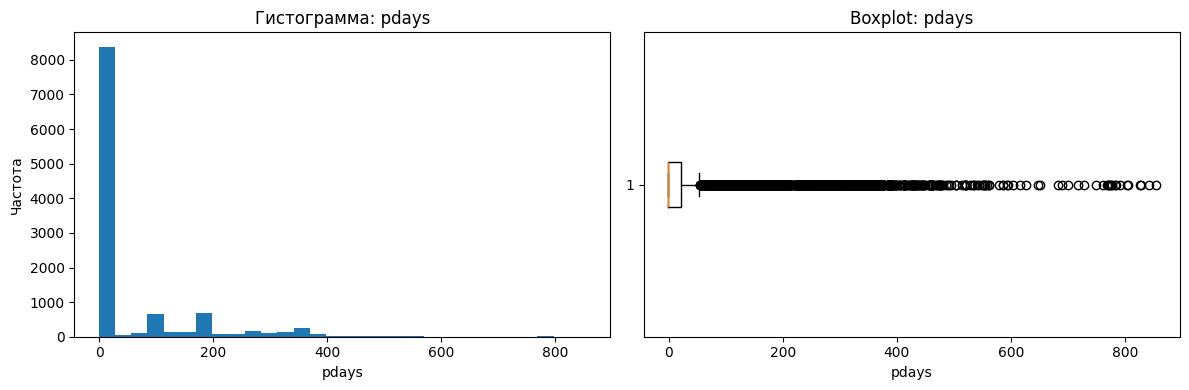

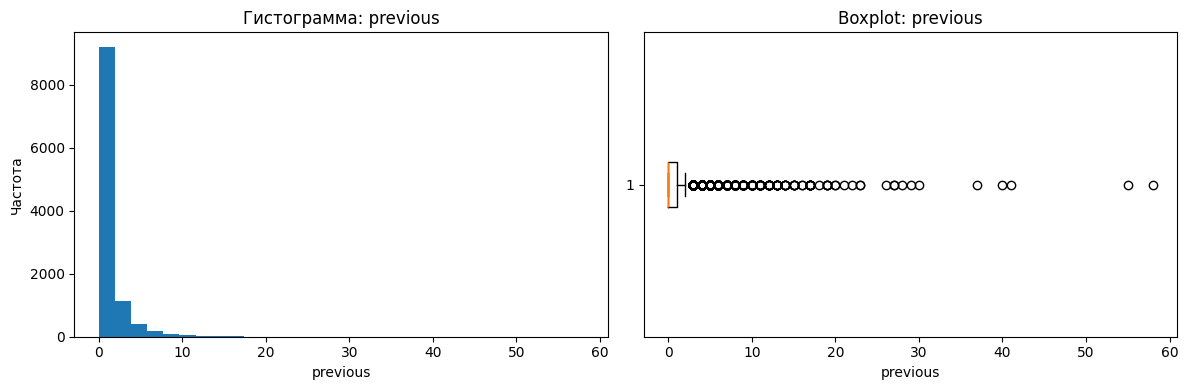

In [291]:
quant_cols = df.select_dtypes(include='number').columns
desc_stats = df[quant_cols].describe().T
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range']]
print('Максимальный возраст клиента банка:', df['age'].max())
print('Минимальная продолжительность разговора с клиентом (сек):', df['duration'].min())



for col in quant_cols:
    plt.figure(figsize=(12,4))
    
    # Гистограмма
    plt.subplot(1,2,1)
    plt.hist(df[col], bins=30)
    plt.title(f'Гистограмма: {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    
    # Boxplot
    plt.subplot(1,2,2)
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)
    
    plt.tight_layout()
    plt.show()


### Задания 4 и 5

Всего сфер занятости: 11
Сферы занятости: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student']


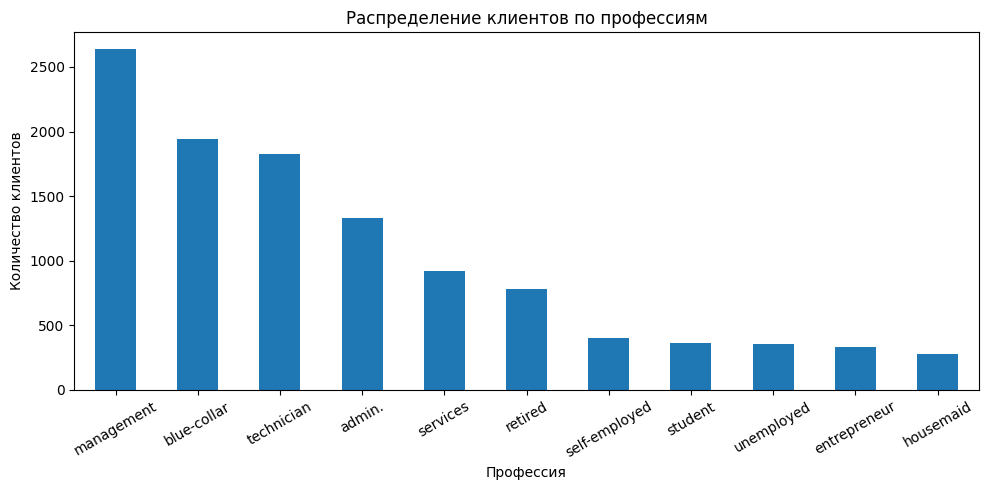

Месяцы, в которые была кампания: ['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']
Всего месяцев: 12


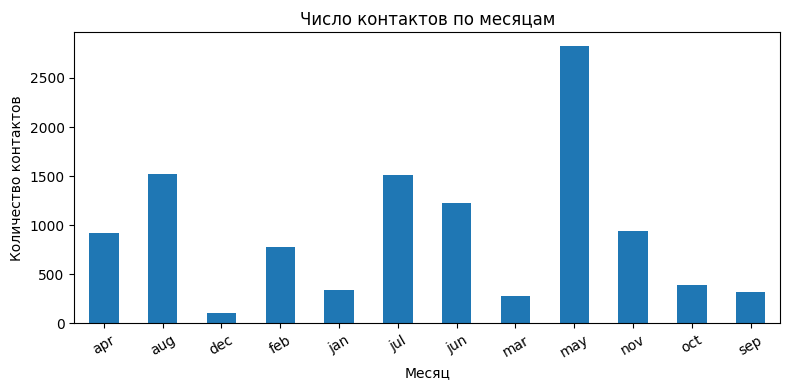

Самое частое семейное положение: married
marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64


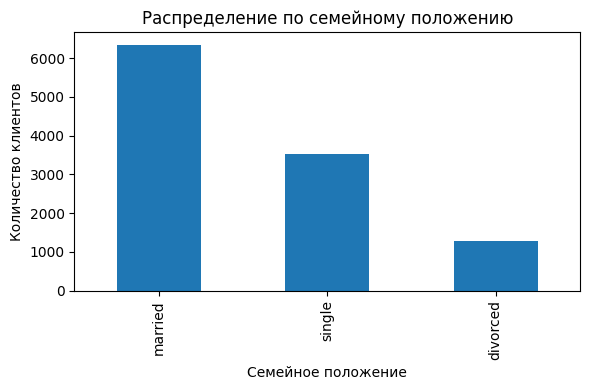

Самый частый уровень образования: secondary
education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64


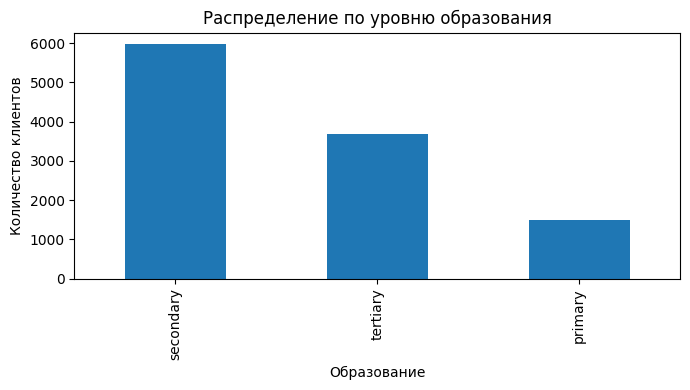

In [292]:
job_unique = df['job'].nunique()
print('Всего сфер занятости:', job_unique)
print('Сферы занятости:', df['job'].unique())

plt.figure(figsize=(10,5))
df['job'].value_counts().plot(kind='bar')
plt.title('Распределение клиентов по профессиям')
plt.xlabel('Профессия')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

months = df['month'].unique()
print('Месяцы, в которые была кампания:', sorted(months))
print('Всего месяцев:', len(months))

plt.figure(figsize=(8,4))
df['month'].value_counts().loc[sorted(df['month'].unique())].plot(kind='bar')
plt.title('Число контактов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество контактов')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

marital_mode = df['marital'].mode()[0]
print('Самое частое семейное положение:', marital_mode)
print(df['marital'].value_counts())

plt.figure(figsize=(6,4))
df['marital'].value_counts().plot(kind='bar')
plt.title('Распределение по семейному положению')
plt.xlabel('Семейное положение')
plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

education_mode = df['education'].mode()[0]
print('Самый частый уровень образования:', education_mode)
print(df['education'].value_counts())

plt.figure(figsize=(7,4))
df['education'].value_counts().plot(kind='bar')
plt.title('Распределение по уровню образования')
plt.xlabel('Образование')
plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

deposit     no   yes
poutcome            
failure    610   618
other      230   307
success     93   978
unknown   4940  3386
Статусы, где успехов больше, чем неудач:
deposit    no  yes
poutcome          
failure   610  618
other     230  307
success    93  978


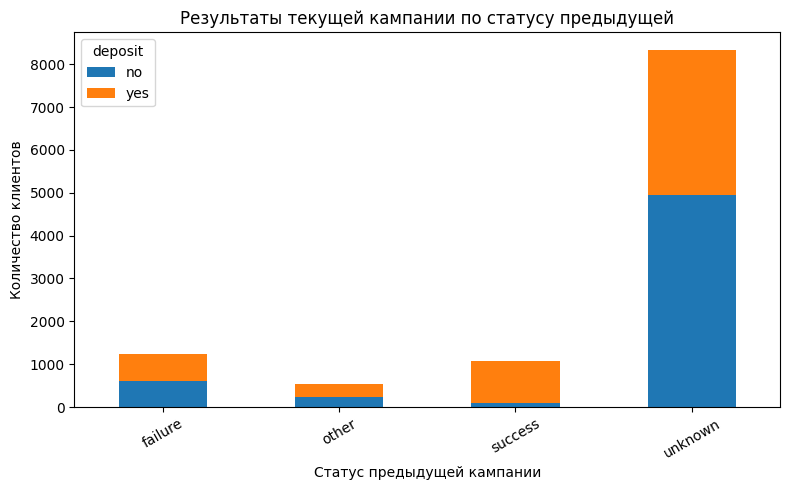

Таблица сопряжённости:
 deposit     no   yes
poutcome            
failure    610   618
other      230   307
success     93   978
unknown   4940  3386 

Статусы предыдущей кампании, где успехов больше, чем неудач:
deposit    no  yes
poutcome          
failure   610  618
other     230  307
success    93  978


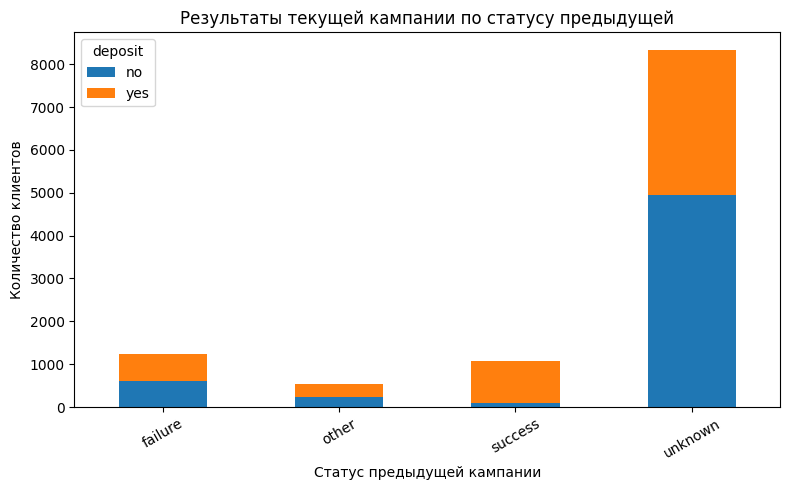

In [293]:
pivot = pd.crosstab(df['poutcome'], df['deposit'])
print(pivot)

# Где успехов больше, чем неудач?
success_poutcome = pivot[pivot['yes'] > pivot['no']]
print('Статусы, где успехов больше, чем неудач:')
print(success_poutcome)

pivot.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Результаты текущей кампании по статусу предыдущей')
plt.xlabel('Статус предыдущей кампании')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Кросстаблица: poutcome vs deposit
pivot = pd.crosstab(df['poutcome'], df['deposit'])
print('Таблица сопряжённости:\n', pivot, '\n')

# Находим статусы, где успехов ("yes") больше, чем неудач ("no")
success_poutcome = pivot[pivot['yes'] > pivot['no']]
print('Статусы предыдущей кампании, где успехов больше, чем неудач:')
print(success_poutcome)

pivot.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Результаты текущей кампании по статусу предыдущей')
plt.xlabel('Статус предыдущей кампании')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [294]:
# Группируем по месяцам и считаем общее количество "no" и общее количество контактов
month_stats = df.groupby('month')['deposit'].value_counts(normalize=True).unstack().fillna(0)

# Берём только процент неудач (значение "no")
month_stats_no = month_stats['no']

# Находим месяц с максимальным процентом неудач
worst_month = month_stats_no.idxmax()
max_percent = month_stats_no.max()

print(f'В месяц {worst_month} самый большой процент неудач: {max_percent:.2%}')


В месяц may самый большой процент неудач: 67.25%


### Задание 8

age_group
30-40    4318
40-50    2628
50-60    1885
<30      1551
60+       780
Name: count, dtype: int64


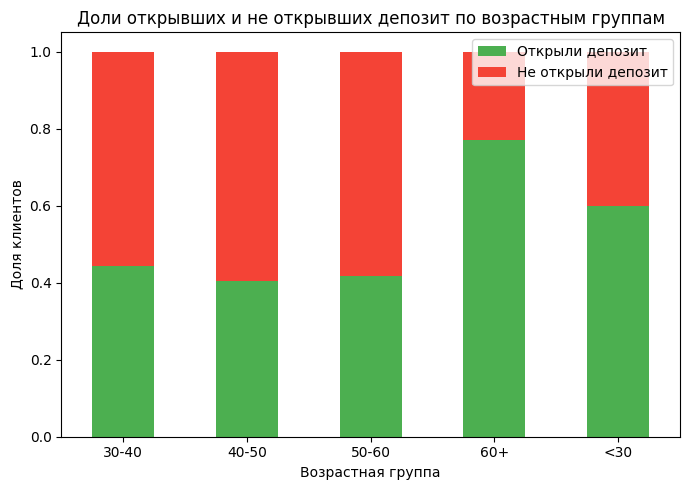

In [295]:
# Функция для категоризации возраста
def age_group(age):
    if age < 30:
        return '<30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    else:
        return '60+'

# Создаём новый столбец 'age_group'
df['age_group'] = df['age'].apply(age_group)

# Посмотрим на распределение по возрастным категориям
print(df['age_group'].value_counts())
# Подсчёт по возрастным группам и целевой переменной
age_deposit = df.groupby('age_group')['deposit'].value_counts(normalize=True).unstack().fillna(0)

# Построение stacked barplot
age_deposit[['yes', 'no']].plot(kind='bar', stacked=True, figsize=(7,5), color=['#4caf50', '#f44336'])
plt.title('Доли открывших и не открывших депозит по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Доля клиентов')
plt.legend(['Открыли депозит', 'Не открыли депозит'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




### Задания 9 и 10

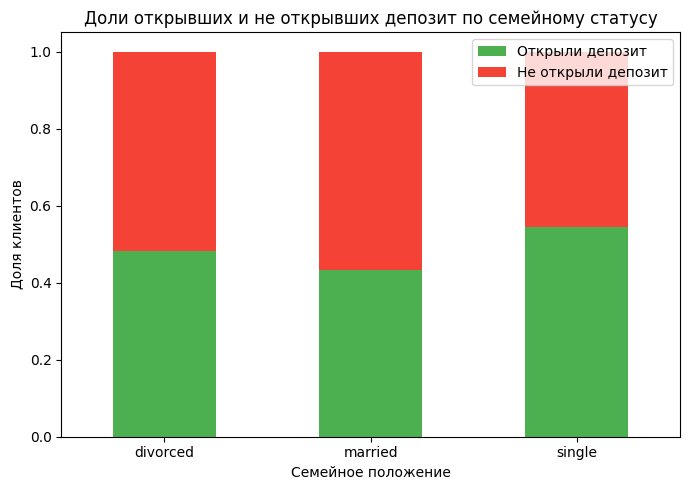

In [296]:
# Считаем доли для каждого семейного положения и факта открытия депозита
marital_deposit = df.groupby('marital')['deposit'].value_counts(normalize=True).unstack().fillna(0)

# Столбчатая диаграмма с накоплением (относительные доли)
marital_deposit[['yes', 'no']].plot(kind='bar', stacked=True, figsize=(7,5), color=['#4caf50', '#f44336'])
plt.title('Доли открывших и не открывших депозит по семейному статусу')
plt.xlabel('Семейное положение')
plt.ylabel('Доля клиентов')
plt.legend(['Открыли депозит', 'Не открыли депозит'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

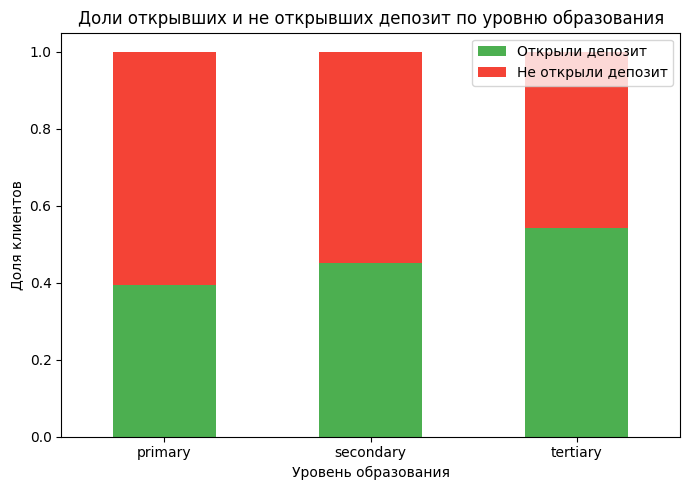

In [297]:

# Группировка по образованию и целевой переменной (относительные доли)
education_deposit = df.groupby('education')['deposit'].value_counts(normalize=True).unstack().fillna(0)

# Визуализация
education_deposit[['yes', 'no']].plot(kind='bar', stacked=True, figsize=(7,5), color=['#4caf50', '#f44336'])
plt.title('Доли открывших и не открывших депозит по уровню образования')
plt.xlabel('Уровень образования')
plt.ylabel('Доля клиентов')
plt.legend(['Открыли депозит', 'Не открыли депозит'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


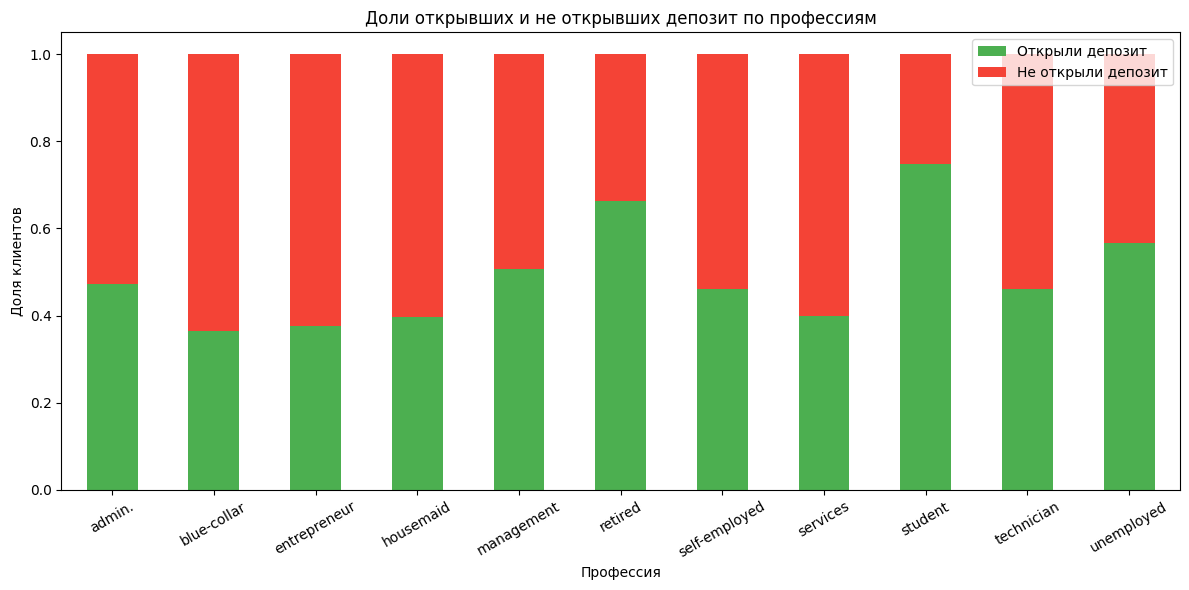

Сфера с наибольшим числом клиентов: management
Сфера с наибольшим числом клиентов: management (2636 клиентов)


In [298]:

# Доли по профессиям и факту открытия депозита
job_deposit = df.groupby('job')['deposit'].value_counts(normalize=True).unstack().fillna(0)

# Построение stacked barplot
job_deposit[['yes', 'no']].plot(kind='bar', stacked=True, figsize=(12,6), color=['#4caf50', '#f44336'])
plt.title('Доли открывших и не открывших депозит по профессиям')
plt.xlabel('Профессия')
plt.ylabel('Доля клиентов')
plt.legend(['Открыли депозит', 'Не открыли депозит'])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

most_common_job = df['job'].mode()[0]
print('Сфера с наибольшим числом клиентов:', most_common_job)
count = df['job'].value_counts()[most_common_job]
print(f'Сфера с наибольшим числом клиентов: {most_common_job} ({count} клиентов)')


### Задание 11

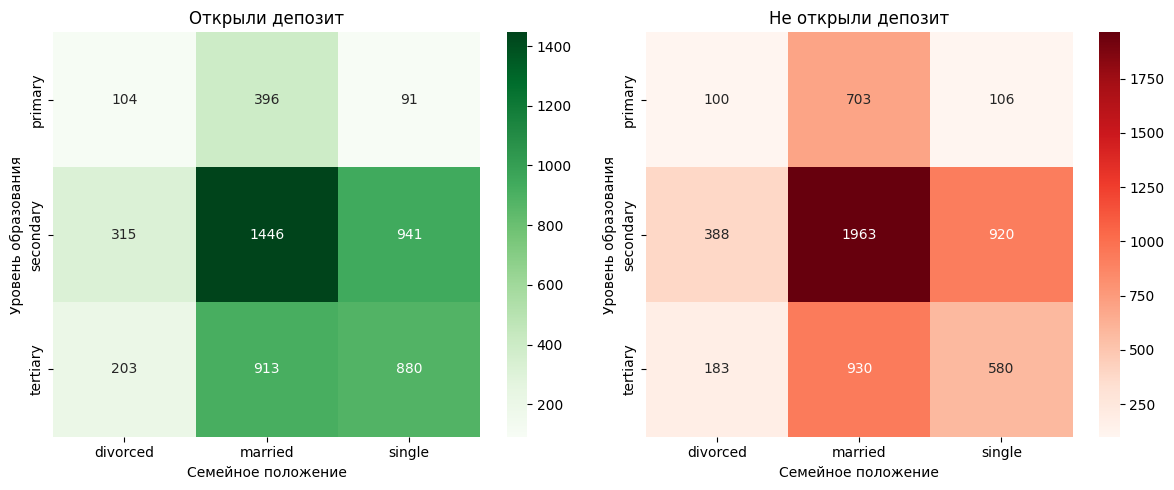

Сводная таблица — Открыли депозит:
marital    divorced  married  single
education                           
primary         104      396      91
secondary       315     1446     941
tertiary        203      913     880

Сводная таблица — Не открыли депозит:
marital    divorced  married  single
education                           
primary         100      703     106
secondary       388     1963     920
tertiary        183      930     580


In [299]:
# 1. Разделение данных
df_yes = df[df['deposit'] == 'yes']
df_no = df[df['deposit'] == 'no']

# 2. Сводные таблицы
pivot_yes = pd.crosstab(df_yes['education'], df_yes['marital'])
pivot_no = pd.crosstab(df_no['education'], df_no['marital'])

# 3. Построение тепловых карт
plt.figure(figsize=(12, 5))

# Тепловая карта для открывших депозит
plt.subplot(1, 2, 1)
sns.heatmap(pivot_yes, annot=True, fmt='d', cmap='Greens')
plt.title('Открыли депозит')
plt.xlabel('Семейное положение')
plt.ylabel('Уровень образования')

# Тепловая карта для неоткрывших депозит
plt.subplot(1, 2, 2)
sns.heatmap(pivot_no, annot=True, fmt='d', cmap='Reds')
plt.title('Не открыли депозит')
plt.xlabel('Семейное положение')
plt.ylabel('Уровень образования')

plt.tight_layout()
plt.show()

# 4. Вывод сводных таблиц
print("Сводная таблица — Открыли депозит:")
print(pivot_yes)
print("\nСводная таблица — Не открыли депозит:")
print(pivot_no)

## Часть 3: преобразование данных

### Задание 1

In [300]:
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])

# Находим сумму закодированных значений
education_encoded_sum = df['education'].sum()

print('Сумма закодированных значений education:', education_encoded_sum)

le_age = LabelEncoder()
df['age_group'] = le_age.fit_transform(df['age_group'])

print('Сумма закодированных значений age_group:', df['age_group'].sum())

Сумма закодированных значений education: 13351
Сумма закодированных значений age_group: 14942


### Задания 2 и 3

In [301]:
# Перекодируем значения прямо в исходных столбцах (заменяя 'yes' на 1, 'no' на 0)
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})
df['default'] = df['default'].map({'yes': 1, 'no': 0})
df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})


std_deposit = round(df['deposit'].std(), 3)
print(f'Стандартное отклонение: {std_deposit}')

default_mean = df['default'].mean()
housing_mean = df['housing'].mean()
loan_mean = df['loan'].mean()

result = round(default_mean + housing_mean + loan_mean, 3)
print(f'Сумма средних: {result}')



Стандартное отклонение: 0.499
Сумма средних: 0.619


### Задание 4

In [302]:
nominal_cols = ['job', 'marital', 'contact', 'month', 'poutcome']

# Создаём dummy-переменные и объединяем их с исходным датафреймом
df = pd.concat([df, pd.get_dummies(df[nominal_cols], prefix=nominal_cols, drop_first=False)], axis=1)

# Проверим, что признаки добавились:
print(df.columns[-20:])  # Показываем последние 20 столбцов для примера

n_features = df.shape[1] - 1  # Всего столбцов минус столбец deposit
print('Количество признаков:', n_features)
df.drop(columns=nominal_cols, inplace=True)
df = df.drop('age', axis=1)

a_features = df.shape[1] - 1 
print('Количество признаков:', a_features)


Index(['marital_single', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')
Количество признаков: 50
Количество признаков: 44


### Задания 5 и 6

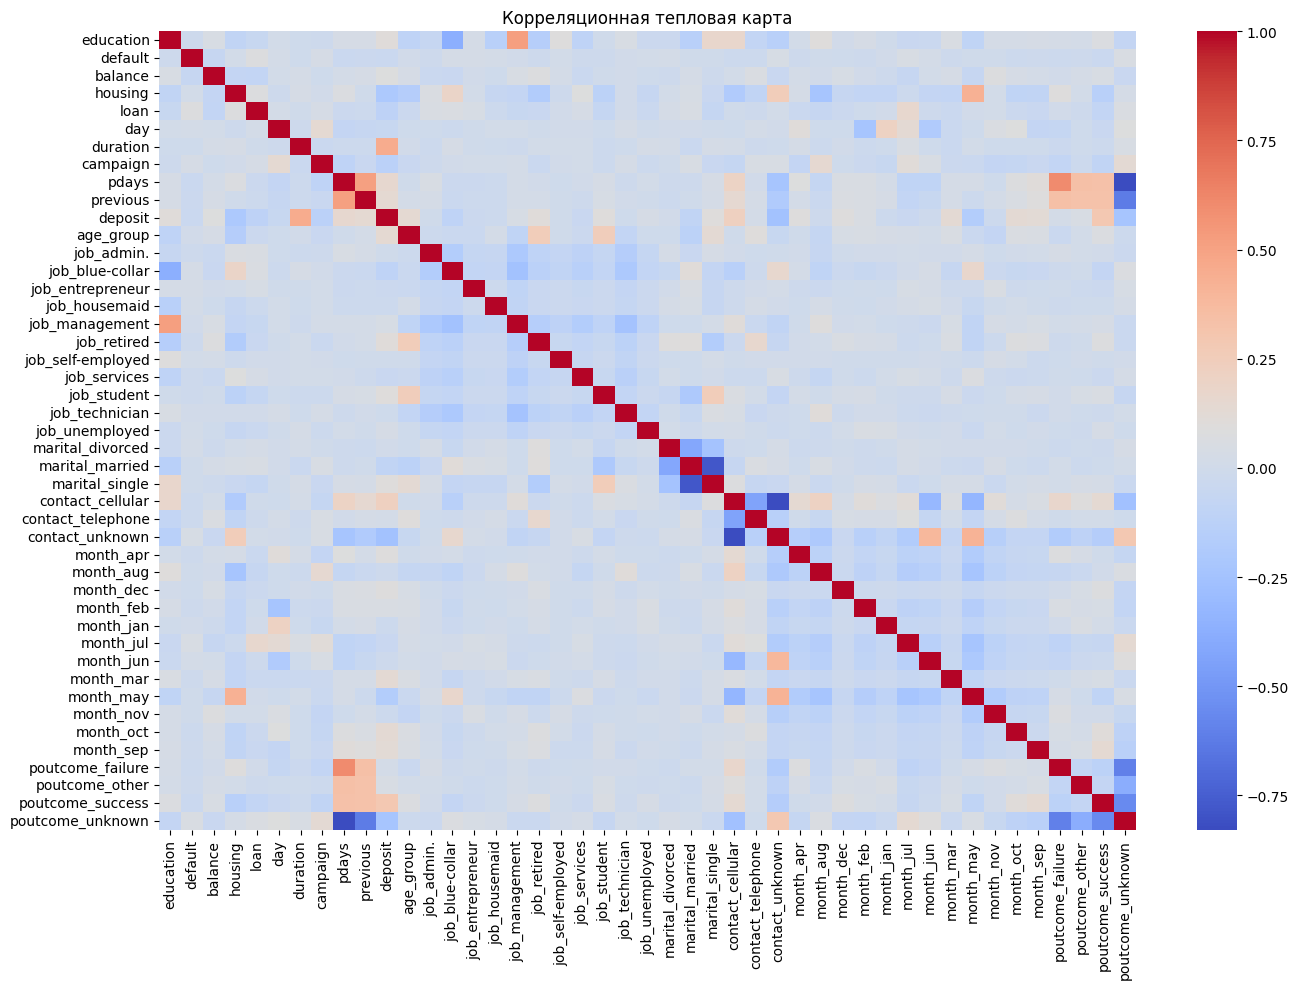

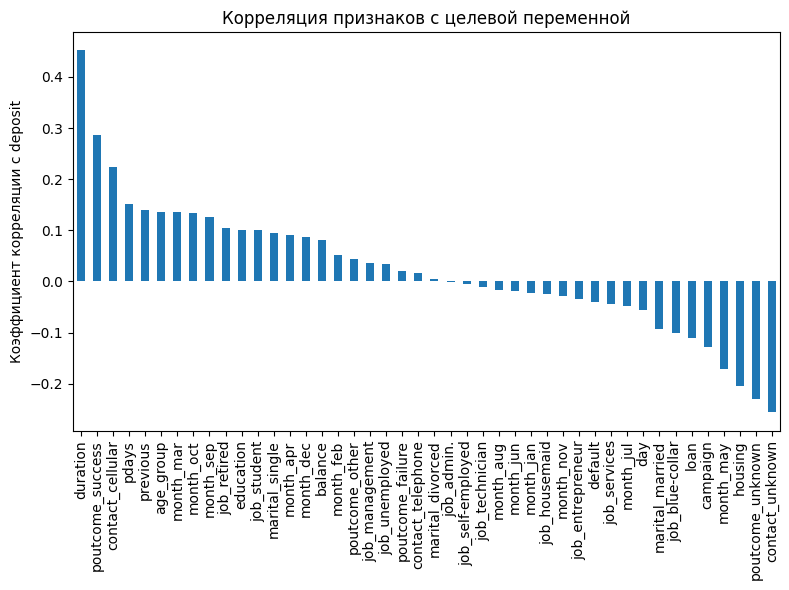

duration             0.451919
poutcome_success     0.286642
contact_unknown      0.256136
poutcome_unknown     0.230470
contact_cellular     0.223252
housing              0.203888
month_may            0.170507
pdays                0.151593
previous             0.139867
age_group            0.136090
month_mar            0.135438
month_oct            0.133783
campaign             0.128081
month_sep            0.126901
loan                 0.110580
job_retired          0.103827
education            0.101049
job_blue-collar      0.100840
job_student          0.099953
marital_single       0.094632
marital_married      0.092157
month_apr            0.090975
month_dec            0.086964
balance              0.081150
day                  0.056326
month_feb            0.051710
month_jul            0.047368
job_services         0.044531
poutcome_other       0.044059
default              0.040680
job_management       0.036313
job_entrepreneur     0.034443
job_unemployed       0.033487
month_nov 

In [303]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})
# 1. Корреляционная матрица (по всем числовым признакам, включая целевую переменную)
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Корреляционная тепловая карта')
plt.tight_layout()
plt.show()

# Столбчатая диаграмма для связи с целевой переменной
target_corr = corr_matrix['deposit'].drop('deposit').sort_values(ascending=False)
target_corr.plot(kind='bar', figsize=(8, 6))
plt.title('Корреляция признаков с целевой переменной')
plt.ylabel('Коэффициент корреляции с deposit')
plt.tight_layout()
plt.show()

# Получаем корреляции с целевой переменной
target_corr = df.corr(numeric_only=True)['deposit'].drop('deposit')

# Сортируем по убыванию абсолютного значения корреляции
sorted_corr = target_corr.abs().sort_values(ascending=False)

# Теперь выведем признаки по убыванию силы взаимосвязи
print(sorted_corr)

# Корреляционная матрица только по признакам (без целевой переменной)
feature_corr = df.drop(columns=['deposit']).corr(numeric_only=True)

# Найдём пары признаков с |corr| >= 0.9 (и не сам с собой)
strong_corr = (
    feature_corr.where(~np.eye(feature_corr.shape[0], dtype=bool))  # убираем диагональ
    .abs()
    .stack()
    .reset_index()
)
strong_corr.columns = ['feature1', 'feature2', 'corr']
strong_corr = strong_corr[strong_corr['corr'] >= 0.9]

print('\nПары признаков с корреляцией >= 0.9:')
print(strong_corr)


### Задания 7 и 8

In [278]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [304]:
print('Размер тестовой выборки:', len(X_test))

mean_target_test = round(y_test.mean(), 2)
print(f'Среднее значение целевой переменной в тестовой выборке: {mean_target_test}')

Размер тестовой выборки: 3684
Среднее значение целевой переменной в тестовой выборке: 0.47


### Задание 9

In [305]:

selector = SelectKBest(score_func=f_classif, k=15)
selector.fit_transform(X_train, y_train)
selector.get_feature_names_out()
# best_indices = selector.get_support(indices=True)
# best_features = X_train.columns[best_indices]

# print('Топ-15 лучших признаков:')
# for f in best_features:
#     print(f)

array(['housing', 'loan', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [179]:
from sklearn.preprocessing import MinMaxScaler
# Оставляем только числовые признаки
X_train_num = X_train.select_dtypes(include='number')
X_test_num = X_test.select_dtypes(include='number')

# Создаём scaler и обучаем только на обучающих данных!
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

# Если нужен DataFrame c теми же именами столбцов:
import pandas as pd
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_num.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns, index=X_test.index)

print(X_train_scaled.head())
print(X_test_scaled.head())

first_pred_mean = round(X_test_scaled.iloc[:, 0].mean(), 2)
print(f'Среднее значение первого предиктора в тестовой выборке: {first_pred_mean}')



           age  education  default   balance  housing  loan       day  \
3072  0.306667        0.5      0.0  0.138772      1.0   0.0  0.400000   
5483  0.120000        0.0      0.0  0.078818      0.0   0.0  0.333333   
5011  0.426667        0.5      0.0  0.132900      0.0   0.0  0.133333   
2839  0.760000        0.5      0.0  0.134365      0.0   0.0  0.900000   
4591  0.586667        1.0      0.0  0.077830      1.0   0.0  0.400000   

      duration  campaign     pdays  previous  age_group  
3072  0.074954  0.032258  0.000000  0.000000       0.25  
5483  0.000609  0.000000  0.000000  0.000000       1.00  
5011  0.218769  0.016129  0.000000  0.000000       0.50  
2839  0.154479  0.000000  0.000000  0.000000       0.75  
4591  0.030774  0.000000  0.217082  0.051724       0.75  
            age  education  default   balance  housing  loan       day  \
6029   0.373333        1.0      0.0  0.077762      1.0   0.0  0.333333   
10318  0.173333        0.5      0.0  0.082509      1.0   1.0  0.2

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:


# Логистическая регрессия с указанными параметрами
logreg = LogisticRegression(solver='sag', random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Предсказания
y_pred = logreg.predict(X_test_scaled)

# Оценка качества — accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy на тестовой выборке: {accuracy:.3f}')

# Дополнительно — подробный отчёт по классам
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(round(accuracy, 2))


Accuracy на тестовой выборке: 0.780
              precision    recall  f1-score   support

           0       0.78      0.81      0.80      1938
           1       0.78      0.75      0.76      1746

    accuracy                           0.78      3684
   macro avg       0.78      0.78      0.78      3684
weighted avg       0.78      0.78      0.78      3684

0.78


### Задания 2,3,4

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1938
           1       0.73      0.73      0.73      1746

    accuracy                           0.74      3684
   macro avg       0.74      0.74      0.74      3684
weighted avg       0.74      0.74      0.74      3684

0.74


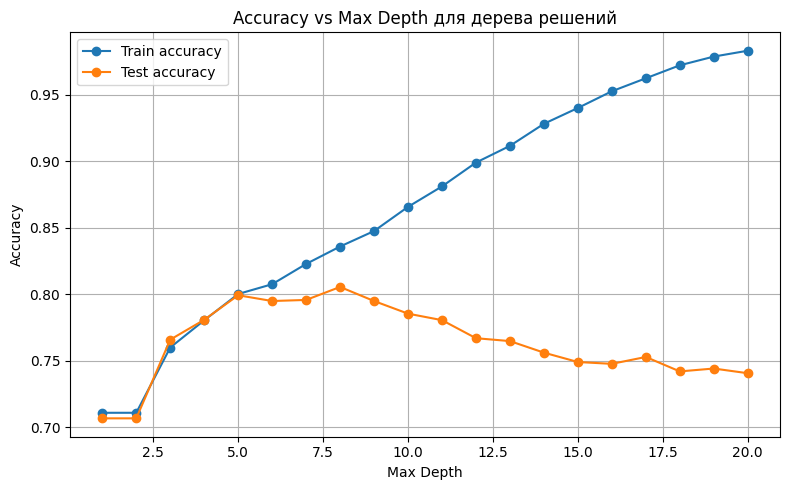

Максимальная accuracy на тесте: 0.806 при глубине: [8]


In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Инициализация и обучение
tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree.fit(X_train_scaled, y_train)

# Предсказание на тестовой выборке
y_pred_tree = tree.predict(X_test_scaled)
print(classification_report(y_test, y_pred_tree))
# Оценка accuracy
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(round(tree_accuracy, 2))

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_accuracies = []
test_accuracies = []
max_depths = range(1, 21)  # Можно увеличить диапазон при необходимости

for depth in max_depths:
    tree = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=depth)
    tree.fit(X_train_scaled, y_train)
    y_pred_train = tree.predict(X_train_scaled)
    y_pred_test = tree.predict(X_test_scaled)
    train_accuracies.append(accuracy_score(y_train, y_pred_train))
    test_accuracies.append(accuracy_score(y_test, y_pred_test))

plt.figure(figsize=(8,5))
plt.plot(max_depths, train_accuracies, label='Train accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Test accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth для дерева решений')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Найдём глубину, при которой test accuracy максимальна
best_test_acc = max(test_accuracies)
best_depths = [depth for depth, acc in zip(max_depths, test_accuracies) if acc == best_test_acc]

print(f'Максимальная accuracy на тесте: {best_test_acc:.3f} при глубине: {best_depths}')


### Задание 5

In [95]:

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Сетка параметров
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Модель
tree = DecisionTreeClassifier(criterion='entropy', random_state=42)

# GridSearch с кросс-валидацией (например, 5-fold)
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print('Лучшие параметры:', grid_search.best_params_)
print('Лучшее значение accuracy (кросс-валидация):', round(grid_search.best_score_, 3))

# Если хочешь применить лучшую модель к тестовой выборке:
best_tree = grid_search.best_estimator_
test_accuracy = best_tree.score(X_test_scaled, y_test)
print('Accuracy на тестовой выборке для оптимальных параметров:', round(test_accuracy, 3))

# accuracy на тестовой выборке для лучшей модели после GridSearch
test_accuracy = best_tree.score(X_test_scaled, y_test)
print(round(test_accuracy, 2))




Лучшие параметры: {'max_depth': 5, 'min_samples_split': 2}
Лучшее значение accuracy (кросс-валидация): 0.792
Accuracy на тестовой выборке для оптимальных параметров: 0.799
0.8


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score

# Обучаем случайный лес с указанными параметрами
rf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf.fit(X_train_scaled, y_train)

# Предсказания
y_pred_rf = rf.predict(X_test_scaled)

# Accuracy
rf_accuracy = round(accuracy_score(y_test, y_pred_rf), 2)
print('Accuracy:', rf_accuracy)

# Recall (по классу "1" — открытие депозита)
rf_recall = round(recall_score(y_test, y_pred_rf), 2)
print('Recall:', rf_recall)


Accuracy: 0.82
Recall: 0.83


### Задания 2 и 3

In [97]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

# Обучаем модель с указанными параметрами
gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

# Предсказания
y_pred_gb = gb.predict(X_test_scaled)

# F1-метрика
gb_f1 = round(f1_score(y_test, y_pred_gb), 2)
print('F1:', gb_f1)


F1: 0.81


### Задание 4

In [98]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score

# Базовые алгоритмы
estimators = [
    ('tree', DecisionTreeClassifier(criterion='entropy', random_state=42)),
    ('logreg', LogisticRegression(solver='sag', random_state=42, max_iter=1000)),
    ('gb', GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    ))
]

# Мета-модель
final_estimator = LogisticRegression(solver='sag', random_state=42, max_iter=1000)

# Стекинг
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    n_jobs=-1
)

stacking.fit(X_train_scaled, y_train)
y_pred_stack = stacking.predict(X_test_scaled)

# Precision на тестовой выборке
stack_precision = round(precision_score(y_test, y_pred_stack), 2)
print('Precision:', stack_precision)


Precision: 0.81


### Задание 5

In [100]:
import pandas as pd
import numpy as np

# Получаем важности и имена признаков
importances = rf.feature_importances_
feature_names = X_train_scaled.columns

# Соберём в DataFrame
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# Топ-3
top3 = feat_imp
print(top3)


      feature  importance
7    duration    0.537015
9       pdays    0.079885
4     housing    0.065129
3     balance    0.063795
0         age    0.057023
10   previous    0.051876
6         day    0.046397
11  age_group    0.041390
8    campaign    0.027688
1   education    0.016452
5        loan    0.012791
2     default    0.000558


### Задания 6,7,8

In [101]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train_scaled, y_train)
    preds = clf.predict(X_test_scaled)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # Можно увеличить число попыток

print('Лучшие параметры:', study.best_params)
print('Лучшее accuracy на тестовой выборке:', round(study.best_value, 2))


[I 2025-06-10 15:05:58,828] A new study created in memory with name: no-name-5b8ec452-24d9-44c1-92cc-9d6b09a353bb
[I 2025-06-10 15:05:59,046] Trial 0 finished with value: 0.8154180238870793 and parameters: {'n_estimators': 117, 'max_depth': 15, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8154180238870793.
[I 2025-06-10 15:05:59,454] Trial 1 finished with value: 0.8189467969598263 and parameters: {'n_estimators': 178, 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8189467969598263.
[I 2025-06-10 15:05:59,703] Trial 2 finished with value: 0.8165038002171553 and parameters: {'n_estimators': 145, 'max_depth': 12, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8189467969598263.
[I 2025-06-10 15:05:59,909] Trial 3 finished with value: 0.8186753528773073 and parameters: {'n_estimators': 101, 'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8189467969598263.
[I 2025-06-10 15:06:00,269] Trial 4 finished with value: 0.81704668838219

Лучшие параметры: {'n_estimators': 158, 'max_depth': 19, 'min_samples_leaf': 2}
Лучшее accuracy на тестовой выборке: 0.82
